In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path)
sys.path.insert(0, my_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [22]:
import pandas as pd
pd.set_option('display.max.colwidth', 130)

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm 
fm._rebuild() 
%matplotlib inline

!apt -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)


import feedparser
from bs4 import BeautifulSoup as bs
import urllib
import urllib.request as req
import requests

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

from konlpy.tag import Kkma, Okt, Komoran
okt = Okt()
from konlpy.utils import pprint

from collections import Counter

import datetime
from datetime import timedelta

In [23]:
import re

from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('wordnet')
import string

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


from gensim.models import Word2Vec


# 그래프에서 한글표현을 위해 폰트를 설치합니다.
# %config InlineBackend.figure_format = 'retina'

from plotnine import *
import plotnine

import warnings
warnings.filterwarnings("ignore")


remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [163]:
def next_ds(de):
    converted_de = datetime.datetime.strptime(de, '%Y.%m.%d').date()   # de를 datetime 형식으로 변환
    next_day = converted_de + timedelta(days=1)  # 1일 뒤 날짜 구함
    ds = next_day.strftime('%Y.%m.%d')
    return ds

In [164]:
de = '2020.07.03'
next_ds(de)

'2020.07.04'

In [205]:
def get_newsNum(keyword, p_ds, p_de):
    keyword = '+'.join(keyword.split(' '))
    
    last = False
    page_num = 1
    day_list = []   # 날짜 리스트
    title_list = []   # 제목 리스트
    cumNum_list = []   # 일일 누적 기사량 리스트
    
    converted_ds = datetime.datetime.strptime(p_ds, '%Y.%m.%d').date()
    converted_de = datetime.datetime.strptime(p_de, '%Y.%m.%d').date()
    periods = (converted_de - converted_ds).days    # 구하고자 하는 기간을 구함

    ds = p_ds  # 기간으로 주어진 인자의 첫 날짜를 url 쿼리 시작 날짜로 지정

    for period in range(periods + 1):
        de = ds   # 끝나는 날짜는 시작날짜와 동일하게 지정 -> 당일 기사 추출
        period_title = []   # 일별 기사제목 저장 리스트
        while last == False:
            url = "https://search.naver.com/search.naver?&where=news&query={0}&sm=tab_pge&sort=0&photo=0&field=0&reporter_article=&pd=3&ds={1}&de={2}&docid=&nso=so:r,p:,a:all&mynews=1&cluster_rank=238&start={3}&refresh_start=0".format(keyword,ds,de,str(page_num))
            raw = requests.get(url)
            html = raw.content
            soup = bs(html, 'html.parser')

            # 주소 가져오기
            ul = soup.find('ul', {'class' : 'type01'})
            li_list = ul.findAll('li')

            # 연관 뉴스 제외
            for li in li_list:
                try:
                    title = li.dl.dt.a['title']
                    period_title.append(title)   # 날짜별 iteration마다 'YYMM.mm.dd'_title의 리스트를 생성하고 날짜별 기사를 저장 (최종 2차원 리스트로 저장되는 것임)
                except AttributeError:
                    pass

            page = soup.find('div', {'class' : 'paging'})
            page_a_list = page.findAll('a')
            if '다음페이지' in str(page_a_list[-1]):
                page_num += 10
            else:
                last = True
                page_num = 1

        day_list.append(ds)
        cumNum_list.append(len(period_title))
        title_list.append(period_title)
        ds = next_ds(de)
        last=False
    cum_dict = {'day' : day_list,
                'CumNum' : cumNum_list,
                'title':title_list}
    CumNews_df = pd.DataFrame(cum_dict)
    return CumNews_df

In [207]:
get_newsNum('춘천', '2020.06.01', '2020.06.30')

[['춘천시, 지자체 첫 200억원 규모 정부 펀드 결성', '춘천 옛 미군기지 오염…이번엔 ‘폐아스콘’', '“코로나19 예방 위해 실내수영장·헬스장 개방 연기”···6월 2일→16일 변경 [춘천시]', "환경·시민단체 '춘천 캠프페이지 부실정화' 반발 잇따라", '의전비서관 춘천 출신 탁현민 靑 비서관 인사 단행', '베토벤과 춘천', "'전 구간 발주' 춘천~속초 동서고속철 가속도", '춘천시, 응집제 주입 자동화로 수돗물 품질 향상', '춘천지법, ‘아동·가정보호 사건’ 적극 대처', '춘천시, 예비창업자 6월 무료 교육생 모집 및 창업지원금 지급', '춘천시, 수돗물 응집제 자동 주입 시스템 도입', '[춘천]“춘천시민 하나 돼 지역 경제 되살리자”', '춘천시, 예비창업자 6월 무료 교육생 모집 및 창업지원금 지급', '춘천시민단체 "캠프 페이지 기름오염, 국방부가 해결해야"', '춘천 캠프페이지서 유기성 폐기물·건설자재 매립 흔적 파문', '춘천시, 어린이보호구역 정비…17억 원 투입', '춘천시 청년청, 청춘의회 멤버십캠프 운영', '‘춘천인형극제’ 9월 4일 개막…국내 작품만 공연', '베토벤과 춘천', '[춘천]시민장학복지재단 기부금 수익 절반 인건비', '춘천시청에 미세먼지 저감 ‘생활밀착형 숲’ 조성', '춘천박물관 옥상정원서 현대미술을 감상해보세요', '춘천시의회 정례회 개회', '[주민자치 열전] 1.춘천시 퇴계금호타운아파트 입주자 대표회의', '생활개선춘천시聯, 손소독제 만들기 체험', '[춘천]춘천학연구소 워크숍 성료', '[춘천]후평산단 복합문화센터·아름다운 거리 조성', '[춘천]춘천인형극제 코로나 영향 국내 참가작으로만 진행', '[동정]춘천 홍천 2020년 6월 1일', '[토막소식]춘천 홍천 2020년 6월 1일', "춘천시보건소 시민 건강 프로그램 '기지개'", '강릉 미분양관리지역서 제외', '서울 등 출근길 비…낮엔 곳곳 30도 육박 더위', "'10분 수술' 그러나 흔한 부작용… 백내장 치료 전후 주의점", '美 하

,day,CumNum,title
0,2020.06.01,330,"[춘천시, 지자체 첫 200억원 규모 정부 펀드 결성, 춘천 옛 미군기지 오염…이번엔 ‘폐아스콘’, “코로나19 예방 위해 실내수영장·헬스장 개방 연기”···6월 2일→16일 변경 [춘천시], 환경·시민단체 '춘천 캠프페이지 ..."
1,2020.06.02,322,"[국방부 “춘천미군기지 토양오염, 원인 규명 먼저 필요”, 춘천시 '상중도' 자연친화형 관광지 조성…용역 추진, 춘천문화재단, 4일 <토선생, 용궁가다> 무대 올려, 경찰, 90억원대 사기혐의 전 춘천교육장 부인 구속영장 신청..."
2,2020.06.03,427,"[춘천경찰서, 전국 예식장 돌며 축의금 절취 전문 절도단 4명 검거, 춘천시 현충일 추념식 취소…자율분향소 운영, 춘천시, 200억 규모 중소기업육성펀드 협약식, 춘천시, 환경친화적 멀칭 비닐 실증 시험재배 추진, 춘천 평생 ..."
3,2020.06.04,370,"[춘천시 장애인가족지원센터 7월부터 운영, 춘천 옛 캠프페이지 부실정화 범시민대책위 결성, 춘천시민사회단체 ""옛 캠프페이지 오염토양 국방부가 책임져야"", 춘천시, 정부 긴급재난지원금 지급률 98.8%, 시티즌 2001년 FA컵..."
4,2020.06.05,350,"[‘춘천 옛 미군기지 부실 정화 범대위’, 춘천 소양강에 둥지 튼 가마우지떼…배설물 해법 없어 '골머리', 춘천시, 노후경유차 조기 폐차 속도낸다, 춘천시, 내수면 불법 어업 집중단속, 춘천소방서, 화재진압ㆍ인명구조 활동 유공..."
5,2020.06.06,100,"[(2보)춘천서 코로나19 확진자 발생…서울 '리치웨이' 방문 80대 남성, 춘천 코로나19 확진자 발생…리치웨이 방문한 80대 남성, 춘천서 리치웨이 방문 80대 확진자 발생, 시티즌, FA컵 첫 경기서 춘천에 3-0대승! ..."
6,2020.06.07,100,"[화천군, ""춘천지검, 일부 단체 동물학대 고발사건 각하 결정 통보"" 밝혀, 춘천 남이섬 '손 모내기' 체험, 춘천시 ""함께 이겨낸 역사, 오늘 이어갑니다"", 방판업체 리치웨이발 확진 잇따라, 천안 춘천서도 확진, 이은형 언니..."
7,2020.06.08,429,"[춘천 국유림 산불 0.1ha 태우고 3시간만 진화(종합), 춘천시, 특례시 지정위해 국회 방문, 춘천국유림관리소, 농림지 동시발생 병해충 60ha 지상방제 완료, 춘천시 폭염 대비위해 도로 물살포시스템 등 확대, 정선 33도..."
8,2020.06.09,352,"[(2보)춘천 9번째 코로나19 확진자 발생, 서울서 직장 다니던 춘천 20대 코로나19 확진, 춘천시, 정부에 특례시 지정 기준 완화 건의, [카메라뉴스] 제철 맞은 새콤달콤한 춘천 토마토 출하 한창, [리포트]20대 여성 ..."
9,2020.06.10,474,"[춘천시 '청년청' 14일 출범…청년 정책 컨트롤타워, 춘천 굴참나무 숲 등 5곳 ‘국유림 명품숲’ 지정, 춘천시, 스탬프 투어 ‘숨은 춘천 찾기’ 출시, [집중취재] 춘천시동물보호센터, 개소도 하기 전에 증축, 춘천시 특례시..."


NameError: ignored

In [209]:
day_list = []   # 날짜 리스트
title_list = []   # 제목 리스트
cumNum_list = []   # 일일 누적 기사량 리스트

In [217]:
def get_newsNum_v2(keyword, p_ds, p_de):
    keyword = '+'.join(keyword.split(' '))
    
    last = False
    page_num = 1

    converted_ds = datetime.datetime.strptime(p_ds, '%Y.%m.%d').date()
    converted_de = datetime.datetime.strptime(p_de, '%Y.%m.%d').date()
    periods = (converted_de - converted_ds).days    # 구하고자 하는 기간을 구함
    print(periods)
    ds = p_ds  # 기간으로 주어진 인자의 첫 날짜를 url 쿼리 시작 날짜로 지정

    for period in range(periods + 1):
        de = ds   # 끝나는 날짜는 시작날짜와 동일하게 지정 -> 당일 기사 추출
        period_title = []   # 일별 기사제목 저장 리스트
        while last == False:
            url = "https://search.naver.com/search.naver?&where=news&query={0}&sm=tab_pge&sort=0&photo=0&field=0&reporter_article=&pd=3&ds={1}&de={2}&docid=&nso=so:r,p:,a:all&mynews=1&cluster_rank=238&start={3}&refresh_start=0".format(keyword,ds,de,str(page_num))
            raw = requests.get(url)
            html = raw.content
            soup = bs(html, 'html.parser')

            # 주소 가져오기
            ul = soup.find('ul', {'class' : 'type01'})
            li_list = ul.findAll('li')

            # 연관 뉴스 제외
            for li in li_list:
                try:
                    title = li.dl.dt.a['title']
                    period_title.append(title)   # 날짜별 iteration마다 'YYMM.mm.dd'_title의 리스트를 생성하고 날짜별 기사를 저장 (최종 2차원 리스트로 저장되는 것임)
                except AttributeError:
                    pass

            page = soup.find('div', {'class' : 'paging'})
            page_a_list = page.findAll('a')
            if '다음페이지' in str(page_a_list[-1]):
                page_num += 10
            else:
                last = True
                page_num = 1

        day_list.append(ds)
        cumNum_list.append(len(period_title))
        title_list.append(period_title)
        ds = next_ds(de)
        last=False
 

In [211]:
get_newsNum_v2('춘천', '2020.06.01', '2020.06.30')

In [212]:
cum_dict = {'day' : day_list,
            'CumNum' : cumNum_list,
            'title':title_list}
            
CumNews_df = pd.DataFrame(cum_dict)
CumNews_df

,day,CumNum,title
0,2020.06.01,330,"[춘천시, 지자체 첫 200억원 규모 정부 펀드 결성, 춘천 옛 미군기지 오염…이번엔 ‘폐아스콘’, “코로나19 예방 위해 실내수영장·헬스장 개방 연기”···6월 2일→16일 변경 [춘천시], 환경·시민단체 '춘천 캠프페이지 ..."
1,2020.06.02,322,"[국방부 “춘천미군기지 토양오염, 원인 규명 먼저 필요”, 춘천시 '상중도' 자연친화형 관광지 조성…용역 추진, 춘천문화재단, 4일 <토선생, 용궁가다> 무대 올려, 경찰, 90억원대 사기혐의 전 춘천교육장 부인 구속영장 신청..."
2,2020.06.03,427,"[춘천경찰서, 전국 예식장 돌며 축의금 절취 전문 절도단 4명 검거, 춘천시 현충일 추념식 취소…자율분향소 운영, 춘천시, 200억 규모 중소기업육성펀드 협약식, 춘천시, 환경친화적 멀칭 비닐 실증 시험재배 추진, 춘천 평생 ..."
3,2020.06.04,370,"[춘천시 장애인가족지원센터 7월부터 운영, 춘천 옛 캠프페이지 부실정화 범시민대책위 결성, 춘천시민사회단체 ""옛 캠프페이지 오염토양 국방부가 책임져야"", 춘천시, 정부 긴급재난지원금 지급률 98.8%, 시티즌 2001년 FA컵..."
4,2020.06.05,350,"[‘춘천 옛 미군기지 부실 정화 범대위’, 춘천 소양강에 둥지 튼 가마우지떼…배설물 해법 없어 '골머리', 춘천시, 노후경유차 조기 폐차 속도낸다, 춘천시, 내수면 불법 어업 집중단속, 춘천소방서, 화재진압ㆍ인명구조 활동 유공..."
5,2020.06.06,100,"[(2보)춘천서 코로나19 확진자 발생…서울 '리치웨이' 방문 80대 남성, 춘천 코로나19 확진자 발생…리치웨이 방문한 80대 남성, 춘천서 리치웨이 방문 80대 확진자 발생, 대전하나시티즌 춘천에 3-0대승! FA컵 3라운..."
6,2020.06.07,100,"[화천군, ""춘천지검, 일부 단체 동물학대 고발사건 각하 결정 통보"" 밝혀, 춘천 남이섬 '손 모내기' 체험, 춘천시 ""함께 이겨낸 역사, 오늘 이어갑니다"", 방판업체 리치웨이발 확진 잇따라, 천안 춘천서도 확진, 이은형 언니..."
7,2020.06.08,429,"[춘천 국유림 산불 0.1ha 태우고 3시간만 진화(종합), 춘천시, 특례시 지정위해 국회 방문, 춘천국유림관리소, 농림지 동시발생 병해충 60ha 지상방제 완료, 춘천시 폭염 대비위해 도로 물살포시스템 등 확대, 정선 33도..."
8,2020.06.09,352,"[(2보)춘천 9번째 코로나19 확진자 발생, 서울서 직장 다니던 춘천 20대 코로나19 확진, 춘천시, 정부에 특례시 지정 기준 완화 건의, [카메라뉴스] 제철 맞은 새콤달콤한 춘천 토마토 출하 한창, [리포트]20대 여성 ..."
9,2020.06.10,474,"[춘천시 '청년청' 14일 출범…청년 정책 컨트롤타워, 춘천 굴참나무 숲 등 5곳 ‘국유림 명품숲’ 지정, 춘천시, 스탬프 투어 ‘숨은 춘천 찾기’ 출시, [집중취재] 춘천시동물보호센터, 개소도 하기 전에 증축, 춘천시 특례시..."


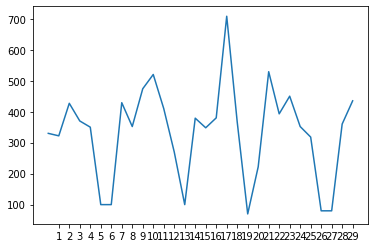

In [216]:
plt.plot(CumNews_df['CumNum'])
plt.xticks(np.arange(1,30))
plt.show()

In [220]:
import seaborn as sns

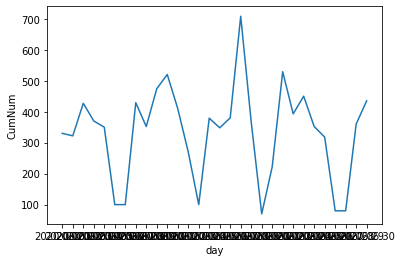

In [223]:
sns.lineplot(x='day', y='CumNum', data=CumNews_df)